# Question 2
You can find this code on my GitHub account: https://github.com/MaximilianJHuber/NYU
## d.)

In [1]:
using Optim
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
p = 0.95; q = 0.95
μ = [0.02, -0.02] #high, low
β = 0.98; γ = 2
Q = [p 1-p; 1-q q];

$$1=\beta\mathbb{E}_t\left[\left(\frac{C_{t+1}}{C_{t}}\right)^{-\gamma}\right] R_{t+1}^{f}=\beta\, Q*\left(\begin{array}{c}
e^{-\gamma\mu_{h}}\\
e^{-\gamma\mu_{l}}
\end{array}\right) R_{t+1}^{f}$$

In [3]:
Rf = β^-1 * (Q*exp((-γ)*μ)).^(-1)

2-element Array{Float64,1}:
 1.05765 
 0.984181

In order to find the price-dividend-ratio $q \in \mathbb{R}^2$ we need to solve:
$$q(s) = \mathbb{E}\left[ \left(\frac{C_{t+1}}{C_{t}}\right)^{-\gamma} \left( q(s') + 1 \right) \mid s \right]$$

In [4]:
res = optimize(q -> norm(β * (Q * (exp((1-γ)*μ) .* (q+1)))- q), [1.,1.], BFGS(), Optim.Options(g_tol=1e-12))

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [1.0,1.0]
 * Minimizer: [49.4040268598965,67.15537139769843]
 * Minimum: 0.000000e+00
 * Iterations: 22
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: true
   * |g(x)| < 1.0e-12: false
   * f(x) > f(x'): false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 185
 * Gradient Calls: 185

In [5]:
PrDi = res.minimizer

2-element Array{Float64,1}:
 49.404 
 67.1554

$$\mathbb{E}_t \left[ R_{t+1} \right] = \mathbb{E}\left[ \frac{C_{t+1}}{C_{t}} \frac{1 + q(s')}{q(s)} \mid s \right]$$

In [6]:
ER = (Q * ((1+PrDi).*exp(μ))) ./ PrDi

2-element Array{Float64,1}:
 1.05642 
 0.983341

In [7]:
ERexcess = ER - Rf

2-element Array{Float64,1}:
 -0.00122676
 -0.0008398 

## e.)
The stationary distribution is the solution to:
$$\pi=Q' \pi$$
that is the right eigenvalues of $Q'$.

In [8]:
π = eigvecs(Q')[:,2] / norm(eigvecs(Q')[:,2],1)

2-element Array{Float64,1}:
 0.5
 0.5

In [9]:
uER = π' * ER

1-element Array{Float64,1}:
 1.01988

In [10]:
uERexcess = π' * ERexcess

1-element Array{Float64,1}:
 -0.00103328

## f.)

$$\mathbb{V}_t\left[R_{t+1} \right] = \mathbb{E} \left[ \left( \frac{1+q(s')}{q(s)} \frac{c_{t+1}(s')}{c_t(s)} \right)^2 \mid s \right] - \left(\mathbb{E}_t \left[R_{t+1} \right] \right)^2$$

In [11]:
function calcReturns(γ::Real; β = 0.98, Q = [0.95 0.05; 0.05 0.95], μ = [0.02, -0.02])
    Rf = β^-1 * (Q*exp((-γ)*μ)).^(-1)
    PrDi = optimize(q -> norm(β * (Q * (exp((1-γ)*μ) .* (q+1)))- q), [1.,1.], 
                    BFGS(), Optim.Options(g_tol=1e-12)).minimizer
    ER = (Q * ((1+PrDi).*exp(μ))) ./ PrDi
    ERexcess = ER - Rf
    π = eigvecs(Q')[:,2] / norm(eigvecs(Q')[:,2],1)
    
    VR = ((Q * (((1+PrDi).^2).*(exp(2.*μ)))) ./ PrDi.^2 - (Q*ER).^2)
    
    return [(π' * ERexcess)[1], sqrt((π' * VR)[1]), (π' * Rf)[1]]
end

calcReturns (generic function with 1 method)

In [12]:
X = Array(Float64,100,3)
γs = linspace(1.1,7,100)
for i in 1:100
    X[i,:] = calcReturns(γs[i])
end


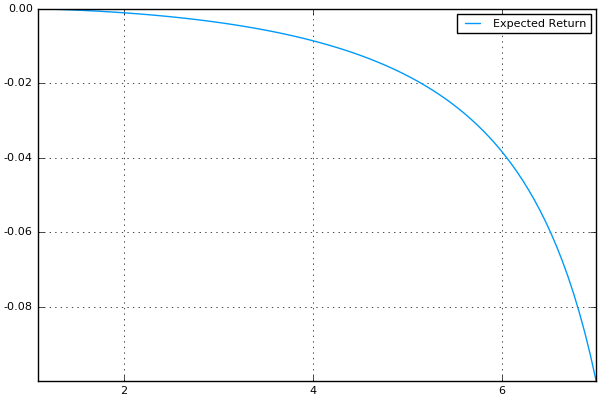

In [13]:
plot(γs, X[:,1], label="Expected Return")


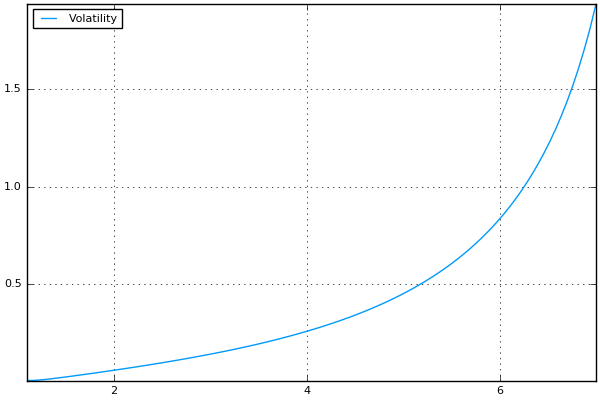

In [14]:
plot(γs, X[:,2], label="Volatility")


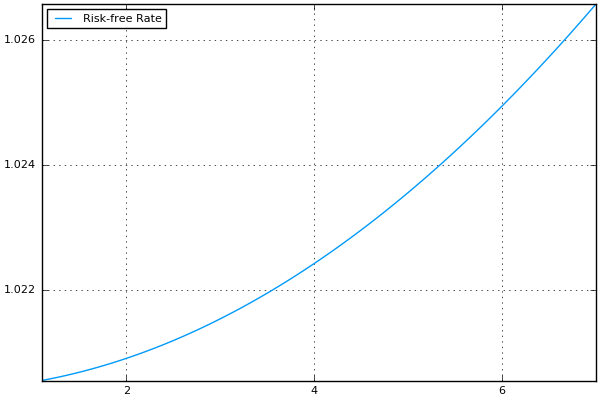

In [15]:
plot(γs, X[:,3], label="Risk-free Rate")

## g.)

In [16]:
function modelMoments(input)
    p = input[1]
    q = p
    μm = input[2]
    δ = input[3]
    
    Q = [p 1-p; 1-p p]
    μ = [μm - δ, μm + δ]
    π = eigvecs(Q')[:,2] / norm(eigvecs(Q')[:,2],1)

    meanC = (π' * μ)[1]
    varC = (π' * (((Q * (μ.^2)) - (Q*μ).^2)))[1]
    acorrC = (μ[1]*μ[1]*p*π[1]+μ[1]*μ[2]*(1-p)*π[1]+μ[2]*μ[1]*(1-q)*π[2]+μ[2]*μ[2]*q*π[2]-(μ[1]*π[1]+μ[2]*π[2])^2)/varC

    return norm([meanC-0.02, 1000*(varC-0.0006), acorrC+0.1])
end

modelMoments (generic function with 1 method)

In [17]:
res = optimize(modelMoments, [0.4, 0.02, 0.03], BFGS(), Optim.Options(g_tol=1e-12))

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [0.4,0.02,0.03]
 * Minimizer: [0.45048918254607934,0.019998963966074416, ...]
 * Minimum: 3.568298e-06
 * Iterations: 20
 * Convergence: false
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-12: false
   * f(x) > f(x'): true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 144
 * Gradient Calls: 144

In [18]:
input = res.minimizer

3-element Array{Float64,1}:
 0.450489 
 0.019999 
 0.0246158